In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

from joblib import dump

In [2]:
path = './'

In [3]:
stop_words = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer()

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (stemmer.stem(w) for w in analyzer(doc))

In [4]:
# import data
data = pd.read_csv(path + 'data.csv')

In [5]:
data = data.set_index('id')

In [6]:
data.head()

,title,overview,genre,text
id,,,,
862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Family,"Toy Story Led by Woody, Andy's toys live happi..."
8844,Jumanji,When siblings Judy and Peter discover an encha...,Family,Jumanji When siblings Judy and Peter discover ...
15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,Romance,Grumpier Old Men A family wedding reignites th...
31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",Drama,"Waiting to Exhale Cheated on, mistreated and s..."
11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy,Father of the Bride Part II Just when George B...


In [9]:
train, test = train_test_split(data, test_size=0.1, random_state=17)

In [10]:
train.shape, test.shape

((37595, 4), (4178, 4))

In [11]:
train['genre'].value_counts()

Drama              13609
Thriller            5617
Comedy              3368
Documentary         3157
Crime               3005
Romance             1699
Family              1643
Horror              1357
Science Fiction     1101
Adventure           1072
Action               783
Animation            459
Fantasy              442
Mystery              283
Name: genre, dtype: int64

In [12]:
test['genre'].value_counts()

Drama              1545
Thriller            617
Documentary         378
Comedy              361
Crime               326
Romance             191
Family              182
Horror              165
Science Fiction     129
Adventure           101
Action               62
Animation            45
Fantasy              44
Mystery              32
Name: genre, dtype: int64

## Rebalance classes

Downsampling of the two most frequent classes (Comedy and Drama) in training set

In [13]:
# keep all samples of other classes
train_no_main = train[~train['genre'].isin(['Comedy', 'Drama'])]

# sample half of comedy movies to rebalance
N_comedy = train['genre'].value_counts().Comedy
sample_comedy = train[train['genre'] == 'Comedy'].sample(N_comedy//2, random_state=29)

# sample half of drama movies to rebalance
N_drama = train['genre'].value_counts().Drama
sample_drama = train[train['genre'] == 'Drama'].sample(N_drama//2, random_state=15)

In [14]:
train_resample = pd.concat([train_no_main, sample_comedy, sample_drama])
train_resample.head()

,title,overview,genre,text
id,,,,
71444,M.D. Geist,"Geist (the main character) is MD-02, a Most Da...",Science Fiction,M.D. Geist Geist (the main character) is MD-02...
1917,Who Killed Bambi?,"Isabelle, a beautiful nursing student, is star...",Thriller,"Who Killed Bambi? Isabelle, a beautiful nursin..."
46776,The Bliss of Mrs. Blossom,"A housewife, bored with her bra-manufacturer h...",Romance,"The Bliss of Mrs. Blossom A housewife, bored w..."
211231,Jonny Quest Vs. The Cyber Insects,The evil Dr. Zin has genetically modified hous...,Adventure,Jonny Quest Vs. The Cyber Insects The evil Dr....
26983,Odds Against Tomorrow,An old-time crook plans a heist. When one of h...,Crime,Odds Against Tomorrow An old-time crook plans ...


In [15]:
train_resample['genre'].value_counts()

Drama              6804
Thriller           5617
Documentary        3157
Crime              3005
Romance            1699
Comedy             1684
Family             1643
Horror             1357
Science Fiction    1101
Adventure          1072
Action              783
Animation           459
Fantasy             442
Mystery             283
Name: genre, dtype: int64

In [16]:
y_train = train_resample['genre'].values

In [17]:
tfidf = StemmedTfidfVectorizer(stop_words=stop_words)

In [18]:
train_tfidf = tfidf.fit_transform(train_resample['text'])

In [19]:
train_tfidf.shape

(29106, 47400)

### Features Reduction

In [50]:
n = 3000
svd = TruncatedSVD(n_components=n, random_state=11)
svd.fit_transform(train_tfidf)
var = np.cumsum(svd.explained_variance_ratio_*100)

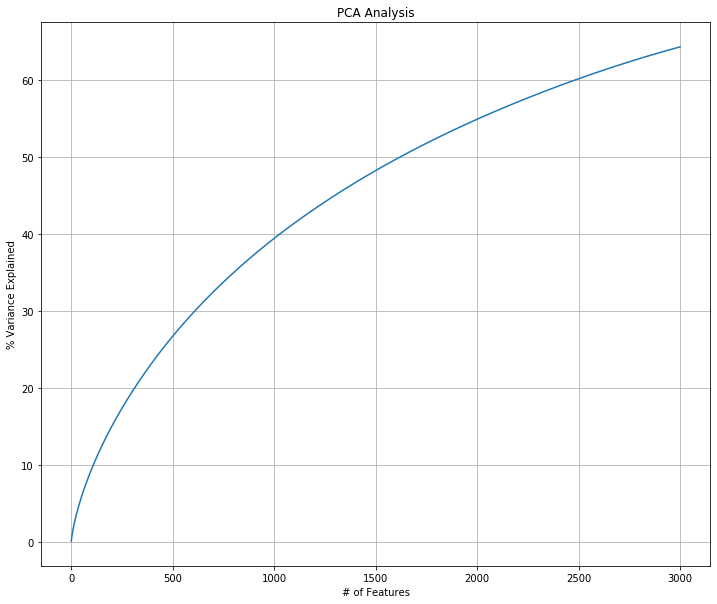

In [51]:
plt.figure(figsize=(12,10))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')

plt.plot(var)
plt.grid()

In [20]:
svd = TruncatedSVD(n_components=600, random_state=11)
X_train = svd.fit_transform(train_tfidf)
print(sum(svd.explained_variance_ratio_))

0.2927763535828874


In [21]:
X_train.shape, y_train.shape

((29106, 600), (29106,))

### Model Selection

In [32]:
# model selection: simple grid-search
parameters = {'n_estimators': [50, 100],
              'class_weight': ['balanced', None],
              'max_depth': [20, 35, 50]
             }
gridsearch = GridSearchCV(RandomForestClassifier(), parameters, cv=4, n_jobs=-1, verbose=10)
gridsearch.fit(X_train, y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:  6.5min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:  6.9min remaining:   47.9s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  7.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  7.6min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [33]:
gridsearch.best_params_, gridsearch.best_score_

({'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 100},
 0.32960070723441875)

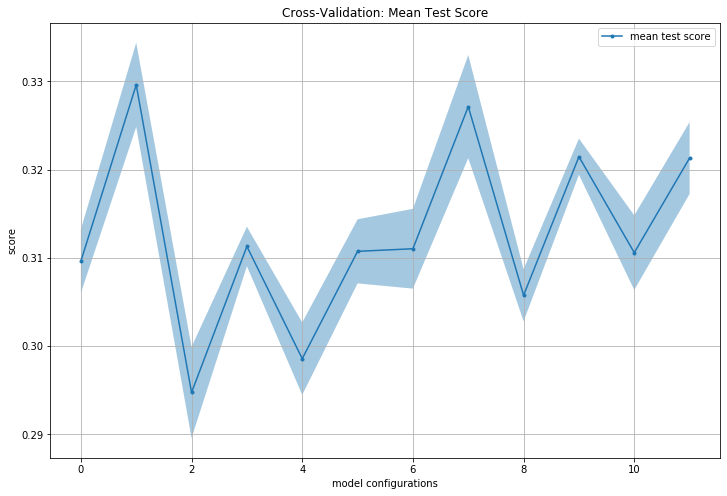

In [34]:
mean_score = gridsearch.cv_results_['mean_test_score']
std_score = gridsearch.cv_results_['std_test_score']

plt.figure(figsize=(12, 8))
plt.plot(mean_score, marker='.', label='mean test score')
plt.fill_between(range(len(mean_score)), 
                 mean_score - std_score,
                 mean_score + std_score,
                 alpha=0.4)
plt.title('Cross-Validation: Mean Test Score')
plt.xlabel('model configurations')
plt.ylabel('score')
plt.legend()
plt.grid()

In [22]:
best_hyp_param = gridsearch.best_params_

### Model train and test

In [23]:
movieclf = RandomForestClassifier(**best_hyp_param, random_state=15)

In [24]:
movieclf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=15, verbose=0, warm_start=False)

In [25]:
# transform test data using tfidf and svd objects fitted with train data
test_tfidf = tfidf.transform(test['text'])
X_test = svd.transform(test_tfidf)

In [26]:
y_test = test['genre'].values

In [27]:
X_test.shape, y_test.shape

((4178, 600), (4178,))

In [28]:
movieclf.score(X_test, y_test)

0.43274293920536144

In [29]:
y_pred = movieclf.predict(X_test)

In [30]:
# use confusion matrix to get an overall idea of performance
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=movieclf.classes_, 
             index=movieclf.classes_
            )

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller
Action,0,0,0,1,15,3,21,0,0,0,0,1,0,21
Adventure,0,2,0,1,2,10,36,3,0,0,0,1,9,37
Animation,0,0,1,2,1,4,22,1,0,0,0,0,1,13
Comedy,0,0,0,30,15,40,205,10,0,0,0,5,1,55
Crime,0,0,0,5,81,17,106,2,0,1,0,2,0,112
Documentary,0,0,1,5,6,266,73,0,0,0,0,1,1,25
Drama,0,4,0,17,43,149,1051,16,0,1,0,24,5,235
Family,0,1,0,7,7,13,92,28,0,1,0,1,1,31
Fantasy,0,1,0,1,0,5,12,1,0,0,0,0,1,23
Horror,0,1,0,2,3,6,47,0,0,8,0,0,2,96


In [31]:
P, R, F1, _ = precision_recall_fscore_support(y_test, y_pred)

/opt/anaconda3/envs/truelayer/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
pd.DataFrame(data=[P, R, F1], columns=movieclf.classes_, index=['precision', 'recall', 'f1'])

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller
precision,0.0,0.153846,0.500000,0.370370,0.317647,0.488073,0.511934,0.405797,0.0,0.615385,0.0,0.180000,0.500000,0.293219
recall,0.0,0.019802,0.022222,0.083102,0.248466,0.703704,0.680259,0.153846,0.0,0.048485,0.0,0.047120,0.193798,0.497569
f1,0.0,0.035088,0.042553,0.135747,0.278830,0.576381,0.584213,0.223108,0.0,0.089888,0.0,0.074689,0.279330,0.368990


### Save classifier, tfidf and svd objects

In [43]:
mpath = 'models/'
dump(movieclf, mpath + 'movieclassifier.joblib')
dump(tfidf, mpath + 'tfidf.joblib')
dump(svd, mpath + 'svd.joblib');